# Overview

The idea for this project is to use a LSTM recurrent neural network to 'finish' an image, given a part of the image. To make this more simple, I'll use grayscale images, so the images will only have 1 channel per pixel instead of 3. That means I'll be making the images with high contrast, basically stencil-type.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from skimage import img_as_ubyte
import skimage
from scipy.misc import imresize
import pyprind
from pyprind import ProgBar, prog_bar
import psutil
from importlib import reload
from libs import utils, gif, nb_utils
import math
import tensorflow as tf
import pyprind
import IPython.display as ipyd

%matplotlib inline
plt.style.use('ggplot')

First, I'll load all my images.

In [3]:
dirname = "./mountain_images/"

filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname) if '.jpg' in fname]

In [4]:
len(filenames)

125

In [5]:
# load all the files into an image object
mountain_imgs = [plt.imread(fname) for fname in filenames]

# Crop every image to a square
mountain_imgs = [utils.imcrop_tosquare(img_i) for img_i in mountain_imgs]

# Then resize the square image to 100 x 100 pixels
mountain_imgs = [resize(img_i, (100, 100)) for img_i in mountain_imgs]

# the `resize` function changes the data to between 0-1, we want to go back to 255
mountain_imgs = [img_as_ubyte(img_i) for img_i in mountain_imgs]

# un-invert the colors
full = np.full([100, 100, 3], 255, dtype='int64')
mountain_imgs = [full - img_i for img_i in mountain_imgs]

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


Then convert the images to grayscale with one channel per pixel:

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [7]:
gray_imgs = np.array([rgb2gray(img) for img in mountain_imgs])

Then round those images to either 0 or 1:

In [8]:
gray_imgs /= 255.0

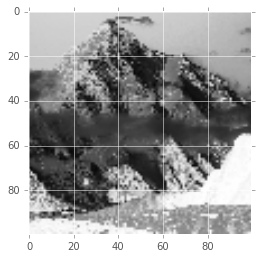

In [9]:
plt.imshow(gray_imgs[0], cmap='gray')

Then we need to round to 0 or 1 to make it like a 'stencil':

In [10]:
stencils = []
threshold = 0.5
for i, img in enumerate(gray_imgs):
  new_img = []
  for row_i, row in enumerate(img):
    new_img.append([])
    for idx, pixel in enumerate(row):
      if pixel <= threshold:
        new_img[row_i].append(0)
      else:
        new_img[row_i].append(1)

  stencils.append(new_img)

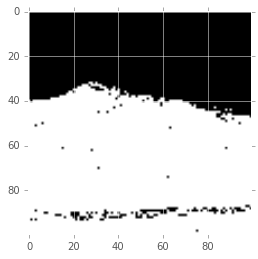

In [11]:
plt.imshow(stencils[np.random.randint(0, len(stencils))], cmap='gray')

Ok, that's not going to work. You can't understand what the image is. What if we used a few more channels? So that you could have 10 possible integer values, and when you 'deprocessed' it back to an image, it would be eithe 0, 0.1, 0.2, 0.3, 0.4, etc.

In [12]:
channeled = []
channels = 10
for i, img in enumerate(gray_imgs):
  new_img = []
  for row_i, row in enumerate(img):
    new_img.append([])
    for idx, pixel in enumerate(row):
      new_img[row_i].append(1 - (round(pixel * channels) / channels))

  channeled.append(new_img)

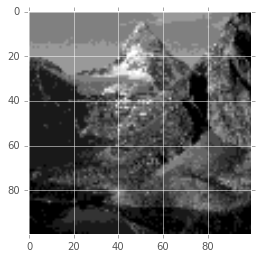

In [13]:
plt.imshow(channeled[np.random.randint(0, len(channeled))], cmap='gray')

Yes, I like it! That should work. So we have `channels` possible 'charachters'.

Now we have an image that is `height x width x 1`. To use an LSTM, we need to flatten out that image into a 1-dimensional array. The `process` function will flatten the image and convert the `float` values per pixel into an integer.

In [14]:
def process(img):
  flattened = np.array(img).flatten()
  flattened *= channels
  flattened = np.rint(flattened)
  flattened = np.array(flattened, dtype='uint8')
  return flattened

In [15]:
processed = process(channeled[0])
print(processed.shape)
print(set(processed))

(10000,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


Then a `deprocess` which will turn a 1-dimensional list of integers to a 2d array of values between 0 and 1.

In [16]:
def deprocess(flattened):
  img = np.array(flattened, dtype='float32')
  img /= channels
  img = img.reshape([100,100])
  return img

In [17]:
print(deprocess(processed).shape)

(100, 100)


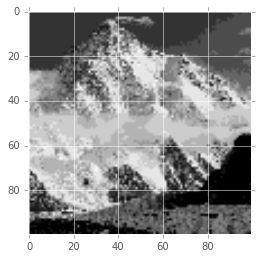

In [18]:
plt.imshow(deprocess(processed), cmap='gray')

Great, so now we have a way to convert a 100x100 image of 0-1 floats into a 10,000 length array with 10 possible integer values. And a way to turn it back.

# The Model

We'll be building an LSTM RNN like in lecture 5 of [Creative Applications of Deep Learning](https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow-iv/info).

In [19]:
tf.reset_default_graph()

Now we'll take all of our images, process them, and flatten them into a single array.

In [20]:
all_processed = np.array([process(img) for img in channeled]).flatten()

In [21]:
print(all_processed.shape)

(1250000,)


In [30]:
# Number of sequences in a mini batch
# This is the height of our processed image, so each 'batch' is
# actually a single image.
batch_size = 100

# Number of characters in a sequence
# This is the width of the processed image, so each row in our
# batch is exactly one row from the image.
sequence_length = 100

# Number of cells in our LSTM layer
n_cells = 256

# Number of LSTM layers
n_layers = 2

vocab = list(set(all_processed))

# Total number of characters in the one-hot encoding
n_chars = len(vocab)

In [31]:
encoder = dict(zip(vocab, range(len(vocab))))
decoder = dict(zip(range(len(vocab)), vocab))

In [32]:
print(n_chars)

11


In [33]:
# A placeholder for the 'input' of our network
X = tf.placeholder(tf.int32, [None, sequence_length], name='X')

# We'll have a placeholder for our true outputs
Y = tf.placeholder(tf.int32, [None, sequence_length], name='Y')

In [34]:
# we first create a variable to take us from our one-hot representation to our LSTM cells
embedding = tf.get_variable("embedding", [n_chars, n_cells])

# And then use tensorflow's embedding lookup to look up the ids in X
Xs = tf.nn.embedding_lookup(embedding, X)

# The resulting lookups are concatenated into a dense tensor
print(Xs.get_shape().as_list())

[None, 100, 256]


In [35]:
with tf.name_scope('reslice'):
    Xs = [tf.squeeze(seq, [1])
          for seq in tf.split(1, sequence_length, Xs)]

In [36]:
cells = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_cells, state_is_tuple=True)

In [37]:
initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

In [38]:
if n_layers > 1:
    cells = tf.nn.rnn_cell.MultiRNNCell(
        [cells] * n_layers, state_is_tuple=True)
    initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

In [39]:
# this will return us a list of outputs of every element in our sequence.
# Each output is `batch_size` x `n_cells` of output.
# It will also return the state as a tuple of the n_cells's memory and
# their output to connect to the time we use the recurrent layer.
outputs, state = tf.nn.rnn(cells, Xs, initial_state=initial_state)

# We'll now stack all our outputs for every cell
outputs_flat = tf.reshape(tf.concat(1, outputs), [-1, n_cells])

In [40]:
with tf.variable_scope('prediction'):
    W = tf.get_variable(
        "W",
        shape=[n_cells, n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))
    b = tf.get_variable(
        "b",
        shape=[n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))

    # Find the output prediction of every single character in our minibatch
    # we denote the pre-activation prediction, logits.
    logits = tf.matmul(outputs_flat, W) + b

    # We get the probabilistic version by calculating the softmax of this
    probs = tf.nn.softmax(logits)

    # And then we can find the index of maximum probability
    Y_pred = tf.argmax(probs, 1)

In [41]:
with tf.variable_scope('loss'):
    # Compute mean cross entropy loss for each output.
    Y_true_flat = tf.reshape(tf.concat(1, Y), [-1])
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, Y_true_flat)
    mean_loss = tf.reduce_mean(loss)

In [42]:
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = []
    clip = tf.constant(5.0, name="clip")
    for grad, var in optimizer.compute_gradients(mean_loss):
        gradients.append((tf.clip_by_value(grad, -clip, clip), var))
    updates = optimizer.apply_gradients(gradients)

Now we will train the prototype of this network. Each 'batch' is a single image, so the output of our network will be the predicted image. After each batch, we'll compare the true image (our input) to the predicted image (the output).

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


0 2.38627


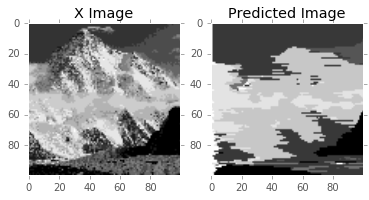

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


1 2.29714


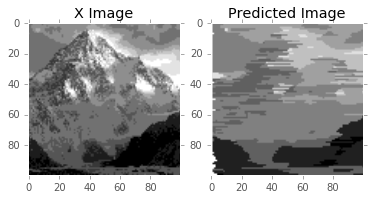

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


2 1.92411


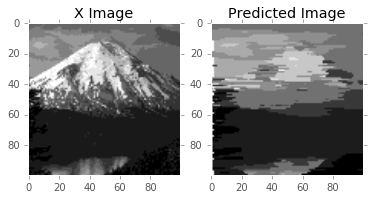

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


3 1.72368


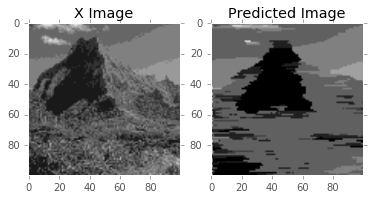

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


4 1.76205


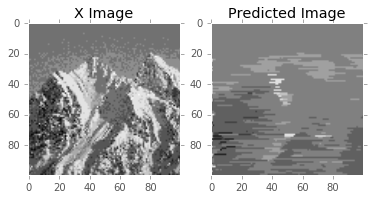

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


5 1.65212


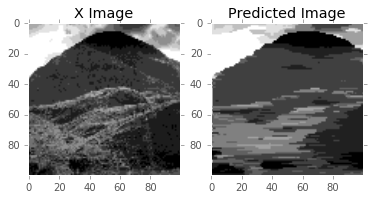

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


6 1.76289


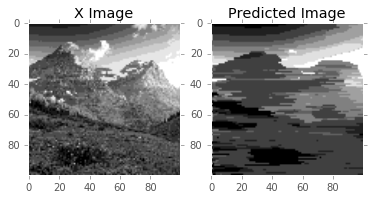

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


7 1.49718


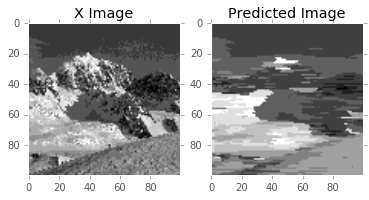

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


8 1.59452


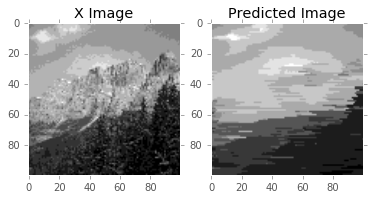

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


9 1.8058


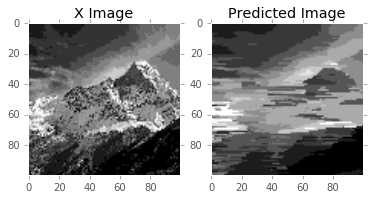

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


10 1.53187


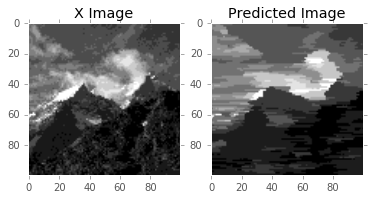

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


11 1.60301


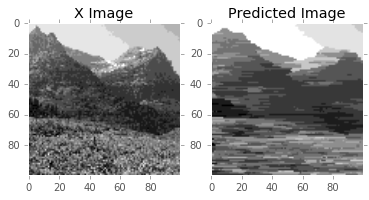

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


12 1.60372


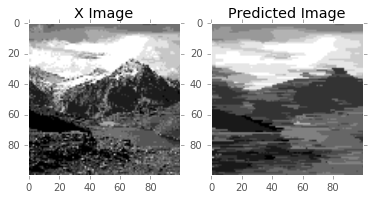

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


13 1.17603


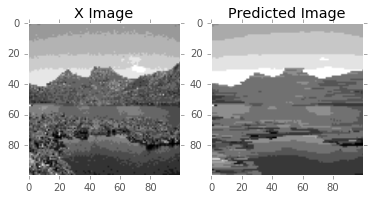

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


14 1.19816


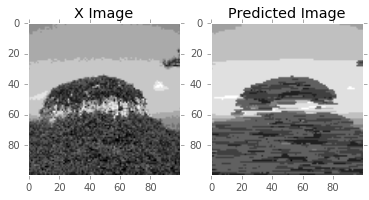

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


15 1.66125


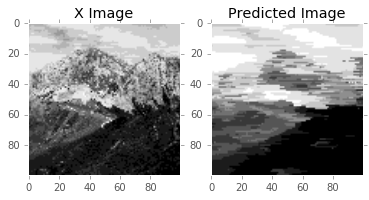

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


16 1.09981


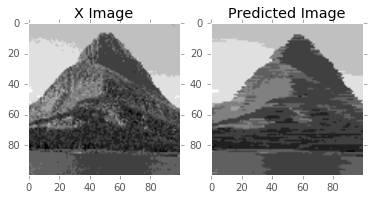

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


17 1.38009


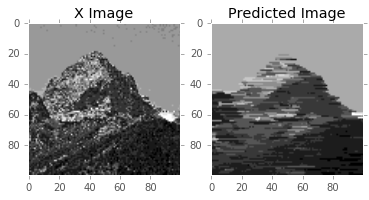

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


18 1.47106


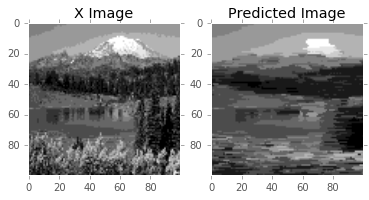

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


19 1.63177


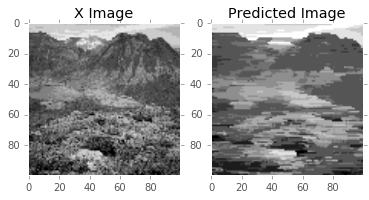

In [43]:
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

txt = all_processed # easier for copypasta

cursor = 0
it_i = 0
for epoch_i in range(20):
  Xs, Ys = [], []
  for batch_i in (range(batch_size):
    if (cursor + sequence_length) >= len(txt) - sequence_length - 1:
        cursor = 0
    Xs.append([ch
               for ch in txt[cursor:cursor + sequence_length]])
    Ys.append([ch
               for ch in txt[cursor + 1: cursor + sequence_length + 1]])

    cursor = (cursor + sequence_length)
  Xs = np.array(Xs).astype(np.int32)
  Ys = np.array(Ys).astype(np.int32)

  loss_val, _ = sess.run([mean_loss, updates],
                         feed_dict={X: Xs, Y: Ys})
  print(it_i, loss_val)

  if it_i % 1 == 0:
    preds = sess.run([Y_pred], feed_dict={X: Xs})[0]
#     preds = [decoder[p_i] for p_i in p]

    x_img = deprocess(Xs.flatten())
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("X Image")
    axs[0].grid('off')
    guessed_img = deprocess(preds)
    axs[1].imshow(guessed_img, cmap='gray')
    axs[1].set_title("Predicted Image")
    axs[1].grid('off')
    plt.show()
#     print(Xs.shape)
#     print(np.array(preds).shape)
#     print(np.array(p).shape)
#     print(np.array(Xs + preds).shape)
        

  it_i += 1

Ok this is turning out pretty cool. I put the model code into a file called 'lstm' to make things easier, and to test different variations of the same network.

In [248]:
from final_project import lstm
reload(lstm)

<module 'final_project.lstm' from '/Users/hank/python/kadenze-tensorflow/session-5/final_project/lstm.py'>

In [ ]:
images = [plt.imread(fname) for fname in filenames]

In [ ]:
images = [lstm.preprocess_img(img) for img in images]

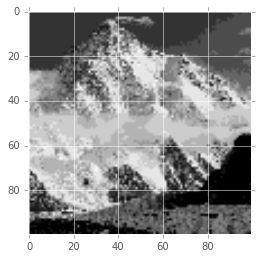

In [181]:
plt.imshow(images[0], cmap='gray')

In [260]:
reload(lstm)
net = lstm.rnn_graph()

In [261]:
nb_utils.show_graph(net['graph'].as_graph_def())

Now I want to train the 'glitch' network. Since we want our output to be extra glitchy, we can't train the network too much. I'll only train a few samples and see what happens.

In [195]:
all_processed = [lstm.process(img) for img in images]

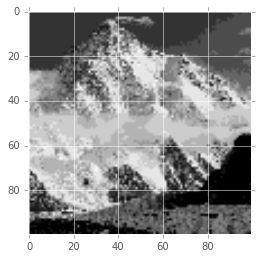

In [197]:
plt.imshow(lstm.deprocess(all_processed[0]), cmap='gray')

In [198]:
txt = np.array(all_processed).flatten()
print(txt.shape)

(1250000,)


In [244]:
sess = tf.Session(graph=net['graph'])

In [262]:
# with session as sess:
with tf.Session(graph=net['graph']) as sess:
  sess.run(tf.initialize_all_variables())

  cursor = 0
  it_i = 0
  train_examples = 10
  for train_i in pyprind.prog_bar(range(train_examples)):
    Xs, Ys = [], []
    for batch_i in range(batch_size):
      if (cursor + sequence_length) >= len(txt) - sequence_length - 1:
          cursor = 0
      Xs.append([ch
                 for ch in txt[cursor:cursor + sequence_length]])
      Ys.append([ch
                 for ch in txt[cursor + 1: cursor + sequence_length + 1]])

      cursor = (cursor + sequence_length)

    Xs = np.array(Xs).astype(np.int32)
    Ys = np.array(Ys).astype(np.int32)

    feed_dict = {}
    feed_dict[net['X']] = Xs
    feed_dict[net['Y']] = Ys

    loss_val, _ = sess.run([net['loss'], net['optimizer']],
                           feed_dict=feed_dict)
    print(it_i, loss_val)

    it_i += 1

  saver = tf.train.Saver()
  saver.save(sess, 'final_glitch.ckpt')

0%      100%
[#         ] | ETA: 00:00:20

0 2.44525


[##        ] | ETA: 00:00:16

1 2.13435


[###       ] | ETA: 00:00:13

2 1.88003


[####      ] | ETA: 00:00:11

3 1.63916


[#####     ] | ETA: 00:00:09

4 1.69372


[######    ] | ETA: 00:00:07

5 1.48746


[#######   ] | ETA: 00:00:05

6 1.60054


[########  ] | ETA: 00:00:03

7 1.38709


[######### ] | ETA: 00:00:01

8 1.45278


[##########] | ETA: 00:00:00

9 1.6



Total time elapsed: 00:00:17


/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([100, 100, 3], 255) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


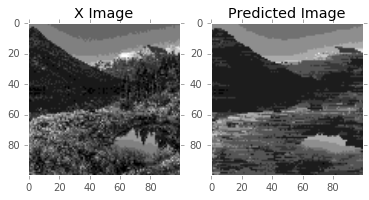

In [250]:
# test_img = mountain_images[np.random.randint(len(mountain_images))]
random_file = filenames[np.random.randint(len(filenames))]
test_img = plt.imread(random_file)
lstm.predict_image(net, test_img)

In [265]:
reload(lstm)

<module 'final_project.lstm' from '/Users/hank/python/kadenze-tensorflow/session-5/final_project/lstm.py'>

In [277]:
%%capture
imgs = []
face = plt.imread('rachael-aligned-v5.jpg')
for i in range(10):
  pred = lstm.predict_image(net, face, display=False)
  imgs.append(resize(pred, (300, 300)))
  
gif.build_gif(imgs=imgs, saveto='glitch.gif', interval=0.1, cmap='gray')

In [278]:
ipyd.Image(url='glitch.gif?i={}'.format(
        np.random.rand()), height=100, width=100)

Awesome, we have a glitchy looking output! I added some dropout to our original graph, so that we get some randomness, which makes the gif look 'noisy'.

Now I'll do this for a bunch of random mountain images, and combine it all into a single GIF. I'll have the actual image come before the output, so we can compare them in the final GIF.

In [280]:
%%capture
n_mountains = 10
n_frames = 20
size = 300

pred_imgs = []
actual_imgs = []
combined_imgs = []

for mountain_i in range(n_mountains):
  random_file = filenames[np.random.randint(len(filenames))]
  test_img = plt.imread(random_file)
  actual_resized = resize(test_img, (size, size))
  
  actual_imgs.append(actual_resized)
  for frame_i in range(n_frames):
    combined_imgs.append(actual_resized)
    
  for frame_i in range(n_frames):
    pred = lstm.predict_image(net, test_img, display=False)
    pred_resized = resize(pred, (size, size))
    pred_imgs.append(pred_resized)
    combined_imgs.append(pred_resized)

face = plt.imread('rachael-aligned-v5.jpg')
face_resized = resize(face, (size, size))
actual_imgs.append(face_resized)
for frame_i in range(n_frames):
  combined_imgs.append(face_resized)
for frame_i in range(n_frames):
  pred = lstm.predict_image(net, face, display=False)
  pred_resized = resize(pred, (size, size))
  pred_imgs.append(pred_resized)
  combined_imgs.append(pred_resized)

In [284]:
print(len(combined_imgs))

440


Now I need to convert the 'actual' images to grayscale so we can use them in the same GIF as the predicted images.

In [285]:
gray_combined_imgs = []
for i, img in enumerate(combined_imgs):
  if img.shape == (300, 300):
    gray_combined_imgs.append(img)
  else:
    gray = np.dot(img[...,:3], [0.299, 0.587, 0.114]) / 255.0
    gray_combined_imgs.append(gray)

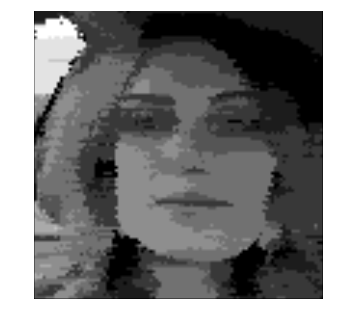

In [286]:
gif.build_gif(imgs=gray_combined_imgs, saveto='glitch-combined.gif', interval=0.1, cmap='gray')

In [288]:
ipyd.Image(url='glitch-combined.gif?i={}'.format(np.random.rand()), height=size, width=size)

Super cool, if I can say so myself! Now I'll train another version of the exact same network, but this time using more samples. We trained the first network on 10 examples, and this one will train on 50 examples. The first one we'll call 'glitch', and the second we'll call 'pixelate'.

In [289]:
net2 = lstm.rnn_graph()

In [290]:
# with session as sess:
with tf.Session(graph=net2['graph']) as sess:
  sess.run(tf.initialize_all_variables())

  cursor = 0
  it_i = 0
  train_examples = 50
  for train_i in pyprind.prog_bar(range(train_examples)):
    Xs, Ys = [], []
    for batch_i in range(batch_size):
      if (cursor + sequence_length) >= len(txt) - sequence_length - 1:
          cursor = 0
      Xs.append([ch
                 for ch in txt[cursor:cursor + sequence_length]])
      Ys.append([ch
                 for ch in txt[cursor + 1: cursor + sequence_length + 1]])

      cursor = (cursor + sequence_length)

    Xs = np.array(Xs).astype(np.int32)
    Ys = np.array(Ys).astype(np.int32)

    feed_dict = {}
    feed_dict[net2['X']] = Xs
    feed_dict[net2['Y']] = Ys

    loss_val, _ = sess.run([net2['loss'], net2['optimizer']],
                           feed_dict=feed_dict)
    print(it_i, loss_val)

    it_i += 1

  saver = tf.train.Saver()
  saver.save(sess, 'final_pixelate.ckpt')

0%                          100%
[                              ]

0 2.51161


[#                             ] | ETA: 00:02:12

1 2.12071
2 1.90616


[##                            ] | ETA: 00:01:44

3 1.58975


[###                           ] | ETA: 00:01:40

4 1.6546
5 1.53687


[####                          ] | ETA: 00:01:31

6 1.60947
7 1.37832


[#####                         ] | ETA: 00:01:25

8 1.431


[######                        ] | ETA: 00:01:23

9 1.60197
10 1.38137


[#######                       ] | ETA: 00:01:18

11 1.55227
12 1.5476


[########                      ] | ETA: 00:01:13

13 1.05658


[#########                     ] | ETA: 00:01:12

14 1.13432
15 1.44476


[##########                    ] | ETA: 00:01:07

16 0.98415
17 1.29174


[###########                   ] | ETA: 00:01:02

18 1.41847


[############                  ] | ETA: 00:01:00

19 1.60824
20 1.23706


[#############                 ] | ETA: 00:00:55

21 0.895003
22 0.875132


[##############                ] | ETA: 00:00:51

23 1.73253


[###############               ] | ETA: 00:00:49

24 0.975754
25 1.17066


[################              ] | ETA: 00:00:46

26 1.42758
27 1.17823


[#################             ] | ETA: 00:00:42

28 1.26164


[##################            ] | ETA: 00:00:41

29 1.0439
30 0.722048


[###################           ] | ETA: 00:00:38

31 1.29685
32 1.2603


[####################          ] | ETA: 00:00:34

33 1.09829


[#####################         ] | ETA: 00:00:32

34 1.36894
35 1.48729


[######################        ] | ETA: 00:00:28

36 1.41125
37 1.46971


[#######################       ] | ETA: 00:00:23

38 1.48187


[########################      ] | ETA: 00:00:21

39 0.779822
40 1.12846


[#########################     ] | ETA: 00:00:16

41 1.4667
42 1.38018


[##########################    ] | ETA: 00:00:12

43 1.43632


[###########################   ] | ETA: 00:00:10

44 1.44259
45 0.77686


[############################  ] | ETA: 00:00:06

46 1.10527
47 0.941712


[############################# ] | ETA: 00:00:01

48 1.26038


[##############################] | ETA: 00:00:00

49 1.18391



Total time elapsed: 00:01:38


In [320]:
reload(lstm)
import time

I put the code for predicting images into a function in the `lstm` file, which speeds up a few of the operations and makes things easier in the notebook.

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


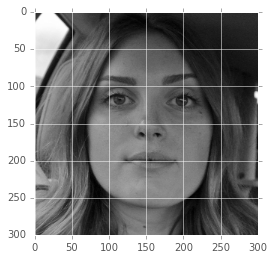

21.482867002487183


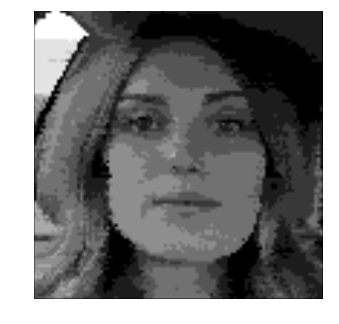

In [318]:
t0 = time.time()
images = [plt.imread('rachael-aligned-v5.jpg')]
generated = lstm.predict_images(net2, images, n_frames=20)
print(time.time() - t0)

gif.build_gif(imgs=generated, saveto='pixelate-face.gif', interval=0.1, cmap='gray')

In [319]:
ipyd.Image(url='pixelate-face.gif?i={}'.format(np.random.rand()), height=size, width=size)

Cool! It's still pixelated and we have the noise that makes it interesting, but there is much more detail in the predicted image.

Now we'll do the same thing with a bunch of mountain images.

In [321]:
imgs_to_pixelate = []

for mountain_i in range(n_mountains):
  random_file = filenames[np.random.randint(len(filenames))]
  imgs_to_pixelate.append(plt.imread(random_file))
  
imgs_to_pixelate.append(plt.imread('rachael-aligned-v5.jpg'))

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precisi

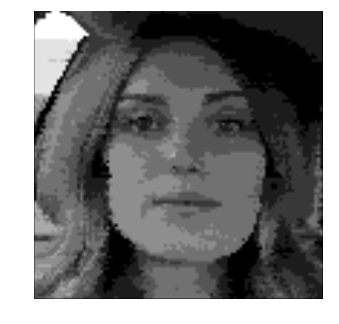

In [322]:
pixelated = lstm.predict_images(net2, imgs_to_pixelate, n_frames=20)

In [ ]:
gif.build_gif(imgs=pixelated, saveto='pixelate-combined.gif', interval=0.1, cmap='gray')

In [46]:
ipyd.Image(url='pixelate-combined.gif?i={}'.format(np.random.rand()), height=size, width=size)

And there you have it! We've used an LSTM infrastructure to generate glitchy and pixelated images. Since the LSTM is outputing a single 1-dimensional string, we get those horizontal lines that make this output unique.

In [ ]:
# This code is used to submit the final project to kadenze.com

utils.build_submission('final-project.zip',
                       ('glitch.gif',
                        '.gif',
                        'final_project/__init__.py',
                        'final_project/lstm.py',
                        'Final Project.ipynb'))